<h1 align="center">Eleven key measures for monitoring general practice clinical activity during COVID-19 using federated analytics on 24 million adults’ primary care records through OpenSAFELY </h1>

**This notebook accompanies [this report](https://reports.opensafely.org/reports/sro-measures/), describing trends and variation in clinical activity codes using a set of key measures indicative of overall activity to evaluate NHS service restoration throughout the COVID-19 pandemic. This version includes data from the EHR provider TPP only and will be updated regularly. For a more detailed analysis please see the report linked above and the accompanying paper.**

For each key measure we provide a link to the codelist containing all the codes used for that measure, a description of what the measure is and a brief overview of why the measure is important.  We also highlight any caveats, where there are any, for each measure.  

Monthly rates of recorded activity are displayed as practice level decile charts to show both the general trend and practice level variation in activity changes. For more information on why we use decile charts to communicate variation in activity, please see [this blog post](https://www.thedatalab.org/blog/2019/04/communicating-variation-in-prescribing-why-we-use-deciles/).

Accompanying each chart is a summary of the most commonly recorded SNOMED codes for each measure. For each measure we also indicate the number of unique patients recorded as having at least one event indicated by the measure as well as the total number of events since January 2019.

The following key measures are provided:

<ul id="docNav">

<li> <a href="#systolic_bp">Blood Pressure Monitoring</a>
<li> <a href="#qrisk2">Cardiovascular Disease 10 Year Risk Assessment</a>
<li> <a href="#cholesterol">Cholesterol Testing</a>
<li> <a href="#ALT">Liver Function Testing - Alanine Transferaminase (ALT)</a>
<li> <a href="#serum_tsh">Thyroid Testing</a>
<li> <a href="#rbc_fbc">Full Blood Count - Red Blood Cell (RBC) Testing</a>
<li> <a href="#hba1c">Glycated Haemoglobin A1c Level (HbA1c)</a>
<li> <a href="#serum_sodium">Renal Function Assessment - Sodium Testing</a>
<li> <a href="#asthma">Asthma Reviews</a>
<li> <a href="#copd">Chronic Obstrutive Pulmonary Disease (COPD) Reviews</a>
<li> <a href="#med_review">Medication Review</a>

</ul>

In [12]:
import pandas as pd
from utilities import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='png'

INTERACTIVE=False

In [13]:
%%capture --no-display

sentinel_measures = ["qrisk2", "asthma", "copd", "sodium", "cholesterol", "alt", "tsh", "rbc", 'hba1c', 'systolic_bp', 'medication_review']

data_dict = {}
num_events_dict = {}

for measure in sentinel_measures:
    df = load_and_drop(measure)
    data_dict[measure] = df
    
data_dict_practice = {}

for measure in sentinel_measures:
    df = load_and_drop(measure, practice=True)
    data_dict_practice[measure] = df

sentinel_measure_codelist_mapping_dict = {"systolic_bp":"opensafely-systolic-blood-pressure-qof", "qrisk2":"opensafely-cvd-risk-assessment-score-qof", "cholesterol": "opensafely-cholesterol-tests", "alt": "opensafely-alanine-aminotransferase-alt-tests", "tsh": "opensafely-thyroid-stimulating-hormone-tsh-testing", "rbc": "opensafely-red-blood-cell-rbc-tests", "hba1c": "opensafely-glycated-haemoglobin-hba1c-tests", "sodium": "opensafely-sodium-tests-numerical-value", "asthma": "opensafely-asthma-annual-review-qof", "copd": "opensafely-chronic-obstructive-pulmonary-disease-copd-review-qof"}

codelist_dict = {}
for measure in sentinel_measures:
    
    if measure == 'medication_review':
        codelist_1 = pd.read_csv('../codelists/opensafely-care-planning-medication-review-simple-reference-set-nhs-digital.csv')
        codelist_1['term'] = codelist_1['term'].str.rstrip('(procedure)').str.rstrip()
        codelist_2 = pd.read_csv('../codelists/nhsd-primary-care-domain-refsets-medrvw_cod.csv')
        codelist_dict[measure] = codelist_1.merge(codelist_2, on=['code', 'term'], how='outer')
    else:
        codelist_name = sentinel_measure_codelist_mapping_dict[measure]
        codelist = pd.read_csv(f'../codelists/{codelist_name}.csv')
        codelist_dict[measure] = codelist



In [14]:
%%capture 
# non-displayed initial run due to gridlines bug
generate_sentinel_measure(data_dict=data_dict, data_dict_practice=data_dict_practice, codelist_dict=codelist_dict, measure='systolic_bp', code_column='code', term_column='term', dates_list=["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/",interactive=INTERACTIVE)

<a id="systolic_bp"></a>
## Blood Pressure Monitoring

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

A commonly-used assessment used to identify patients with hypertension or to ensure optimal treatment for those with known hypertension.  This helps ensure appropriate treatment, with the aim of reducing long term risks of complications from hypertension such as stroke, myocardial infarction and kidney disease. 

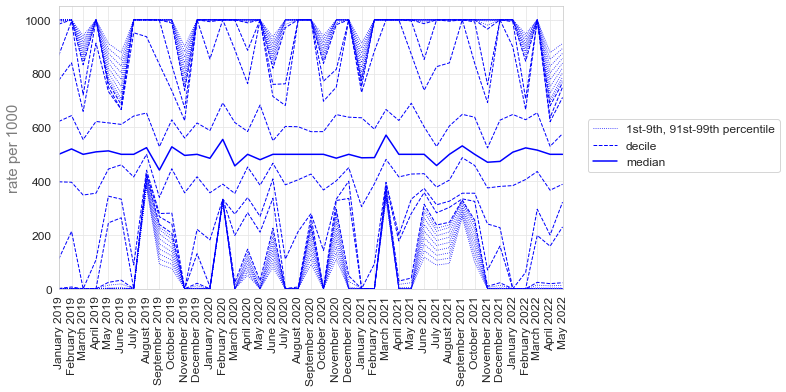

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
198081000000101,Ambulatory systolic blood pressure,59.26
271649006,Systolic blood pressure,22.32
251070002,Non-invasive systolic arterial pressure,18.42


Total patients: 0.01M (0.00M events)

In [15]:
systolic_bp_df, num_events_systolic_bp = generate_sentinel_measure(data_dict=data_dict, data_dict_practice=data_dict_practice, codelist_dict=codelist_dict, measure='systolic_bp', code_column='code', term_column='term', dates_list=["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/systolic-blood-pressure-qof/3572b5fb/",interactive=INTERACTIVE)
num_events_dict["systolic_bp"] = num_events_systolic_bp

<a id="qrisk2"></a>
## Cardiovascular Disease 10 year Risk Assessment

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/">this codelist</a>.

<h3 class="details">What is it and why does it matter? </h3>

A commonly-used risk assessment used to identify patients with an increased risk of cardiovascular events in the next 10 years. This helps ensure appropriate treatment, with the aim of reducing long term risks of complications such as stroke or myocardial infarction. 

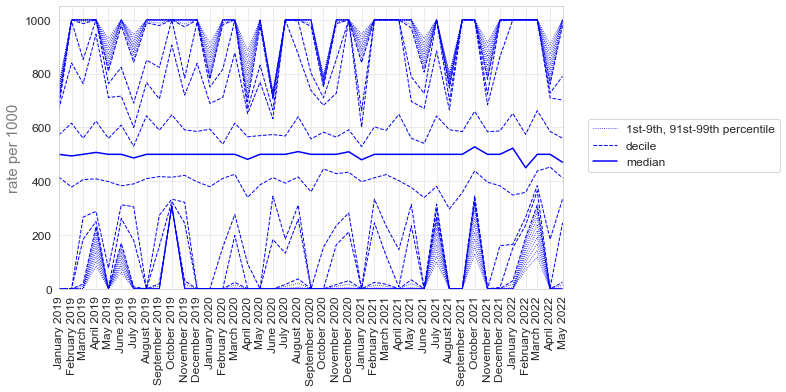

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1085871000000105,QRISK3 cardiovascular disease 10 year risk calculator score,62.09
718087004,QRISK2 cardiovascular disease 10 year risk score,20.11
450759008,Framingham coronary heart disease 10 year risk score,17.8


Total patients: 0.01M (0.00M events)

In [16]:
qrisk2_df, num_events_qrisk2 = generate_sentinel_measure(data_dict=data_dict, data_dict_practice=data_dict_practice, codelist_dict=codelist_dict, measure='qrisk2', code_column='code', term_column='term', dates_list=["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/cvd-risk-assessment-score-qof/1adf44a5/",interactive=INTERACTIVE)
num_events_dict["qrisk2"] = num_events_qrisk2

<a id="cholesterol"></a>
## Cholesterol Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/">Codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

A commonly-used blood test used as part of a routine cardiovascular disease 10 year risk assessment and also to identify patients with lipid disorders (e.g. familial hypercholesterolaemia). This helps ensure appropriate treatment, with the aim of reducing long term risks of complications such as stroke or myocardial infarction.

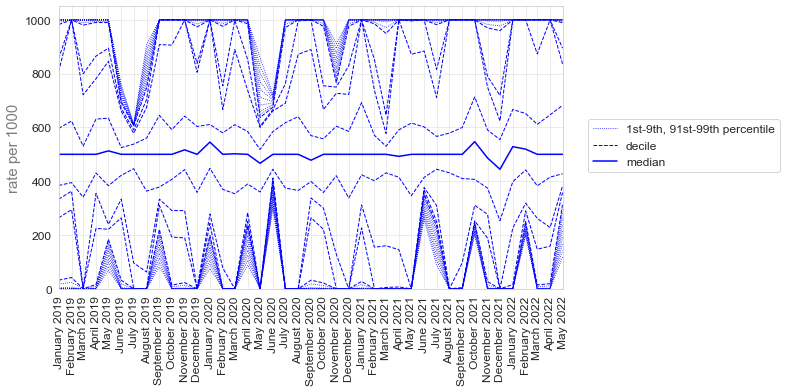

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1005671000000105,Serum cholesterol level,78.35
1017161000000104,Plasma total cholesterol level,21.65


Total patients: 0.01M (0.00M events)

In [17]:
cholesterol_df, num_events_cholesterol = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'cholesterol', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/cholesterol-tests/09896c09/",interactive=INTERACTIVE)
num_events_dict["cholesterol"] = num_events_cholesterol

<a id="ALT"></a>
## Liver Function Testing - Alanine Transferaminase (ALT)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

An ALT blood test is one of a group of liver function tests (LFTs) which are used to detect problems with the function of the liver.  It is often used to monitor patients on medications which may affect the liver or which rely on the liver to break them down within the body. They are also tested for patients with known or suspected liver dysfunction.  

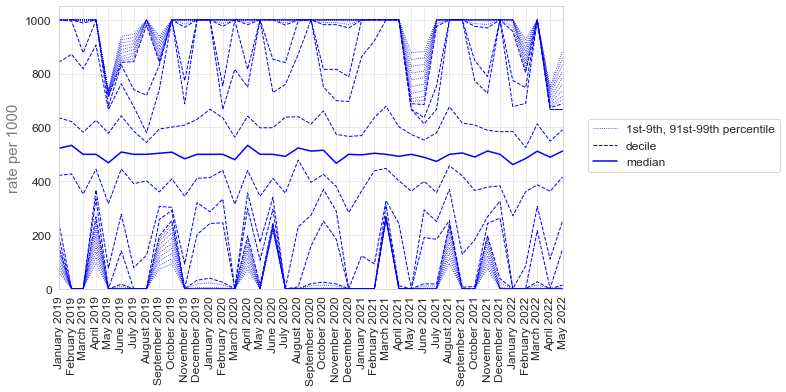

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1013211000000103,Plasma alanine aminotransferase level,79.38
1018251000000107,Serum alanine aminotransferase level,20.62


Total patients: 0.01M (0.00M events)

In [18]:
alt_df, num_events_alt = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'alt', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/alanine-aminotransferase-alt-tests/2298df3e/",interactive=INTERACTIVE)
num_events_dict["alt"] = num_events_alt

<a id="serum_tsh"></a>
## Thyroid Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

TSH is used for the diagnosis and monitoring of hypothyroidism and hyperthyroidism, including making changes to thyroid replacement therapy dosing.

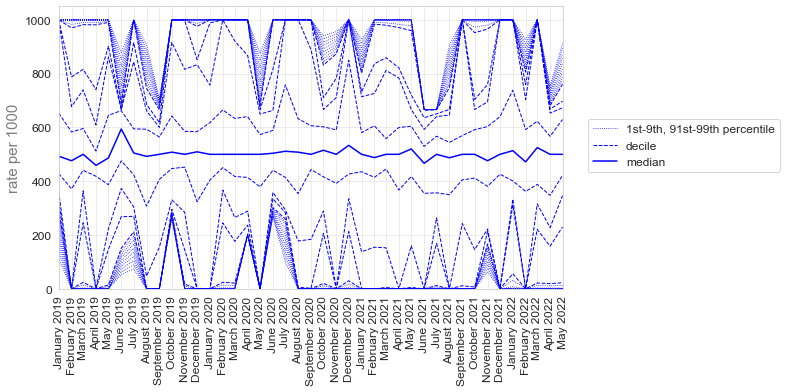

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1022791000000101,Serum thyroid stimulating hormone level,80.42
1022801000000102,Plasma thyroid stimulating hormone level,19.58


Total patients: 0.01M (0.00M events)

In [19]:
tsh_df, num_events_tsh = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'tsh', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/thyroid-stimulating-hormone-tsh-testing/11a1abeb/",interactive=INTERACTIVE)
num_events_dict["tsh"] = num_events_tsh

<a id="rbc_fbc"></a>
## Full Blood Count - Red Blood Cell (RBC) Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

RBC is completed as part of a group of tests referred to as a full blood count (FBC), used to detect a variety of disorders of the blood, such as anaemia and infection.

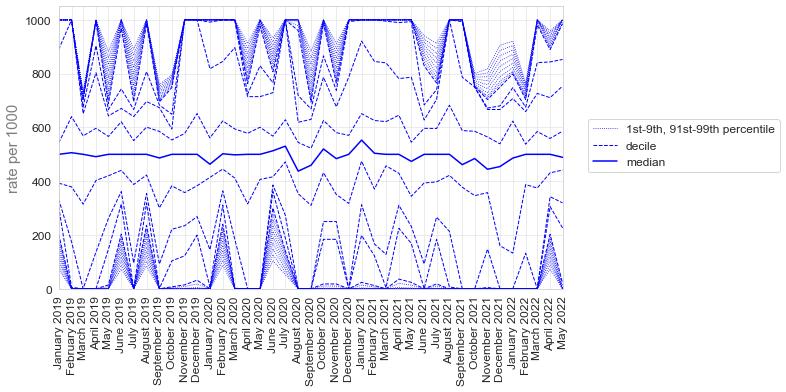

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1022451000000103,Red blood cell count,100.0


Total patients: 0.01M (0.00M events)

In [20]:
rbc_df, num_events_rbc = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'rbc', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/red-blood-cell-rbc-tests/576a859e/",interactive=INTERACTIVE)
num_events_dict["rbc"] = num_events_rbc

<a id="hba1c"></a>
## Glycated Haemoglobin A1c Level (HbA1c)

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

HbA1c is a long term indicator of diabetes control. NICE guidelines recommend that individuals with diabetes have their HbA1c measured at least twice a year. Poor diabetic control can place individuals living with diabetes at an increased risk of the complications of diabetes.

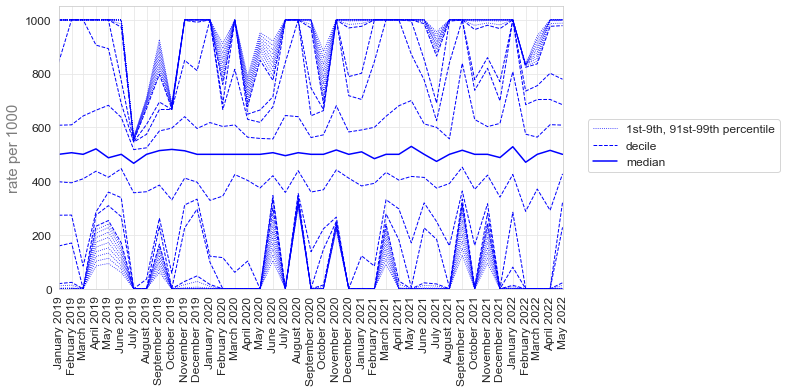

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1003671000000109,Haemoglobin A1c level,60.31
144176003,Haemoglobin A1c level,19.87
166902009,Haemoglobin A1c level,19.82


Total patients: 0.01M (0.00M events)

In [21]:
hba1c_df, num_events_hba1c = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'hba1c', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/glycated-haemoglobin-hba1c-tests/62358576/",interactive=INTERACTIVE)
num_events_dict["hba1c"] = num_events_hba1c


<a id="serum_sodium"></a>
## Renal Function Assessment - Sodium Testing

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/">this codelist</a>.

<h3 class="details">What is it and why does it matter?</h3>

Sodium is completed as part of a group of tests referred to as a renal profile, used to detect a variety of disorders of the kidneys. A renal profile is also often used to monitor patients on medications which may affect the kidneys or which rely on the kidneys to remove them from the body.

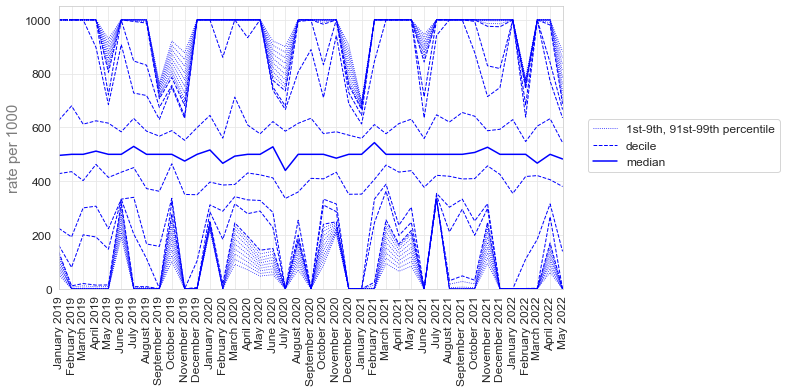

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1000661000000107,Serum sodium level,60.65
1017381000000106,Plasma sodium level,39.35


Total patients: 0.01M (0.00M events)

In [22]:
sodium_df, num_events_sodium = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'sodium', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/sodium-tests-numerical-value/32bff605/",interactive=INTERACTIVE)
num_events_dict["sodium"] = num_events_sodium

<a id="asthma"></a>
## Asthma Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/">this codelist</a>.  QoF recommends a number of codes that can be used by practices as an asthma annual review.  These are all included in our codelist.

<h3 class="details">What is it and why does it matter?</h3>

The British Thoracic Society and Scottish Intercollegiate Guidelines Network on the management of asthma recommend that people with asthma receive a review of their condition at least annually.If a patient has not been reviewed, it is possible that their asthma control may have worsened, leading to a greater chance of symptoms and admission to hospital.

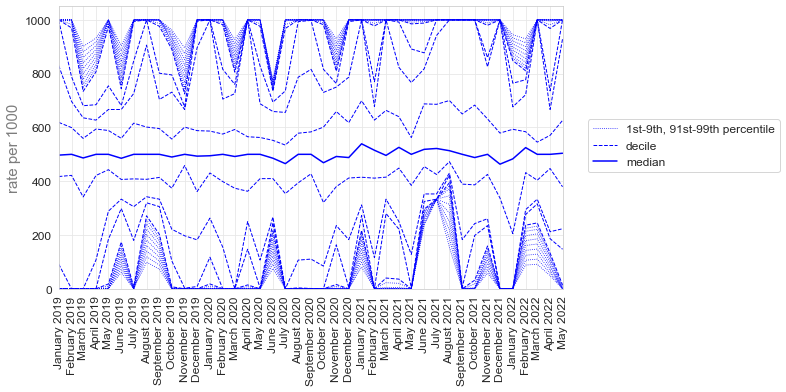

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
270442000,Asthma monitoring check done,59.21
390877003,Step up change in asthma management plan,21.44
390872009,Change in asthma management plan,19.35


Total patients: 0.01M (0.00M events)

In [23]:
asthma_df, num_events_asthma = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'asthma', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/asthma-annual-review-qof/33eeb7da/",interactive=INTERACTIVE)
num_events_dict["asthma"] = num_events_asthma


<a id="copd"></a>
## Chronic Obstructive Pulmonary Disease (COPD) Reviews

The codes used in for this measure are available in <a href="https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/">this codelist</a>.  

<h3 class="details">What is it and why does it matter?</h3>

It is recommended by NICE that all individuals living with COPD have an annual review with the exception of individuals living with very severe (stage 4) COPD being reviewed at least twice a year.
If a patient has not been reviewed, it is possible that their COPD control may have worsened, leading to a greater chance of symptoms and admission to hospital.


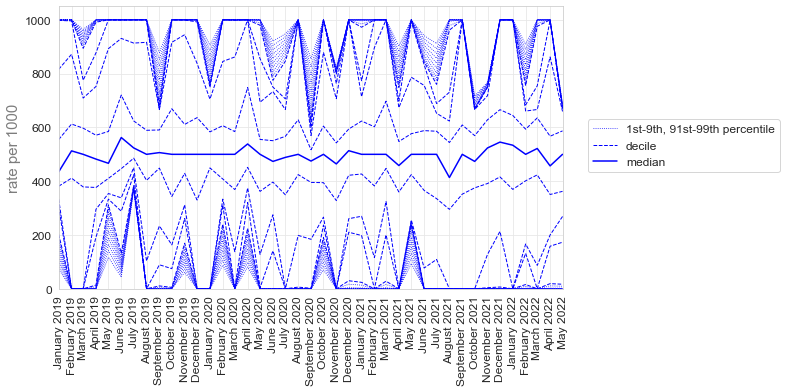

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
394703002,Chronic obstructive pulmonary disease annual review,61.04
760621000000103,Chronic obstructive pulmonary disease 6 monthly review,20.3
760601000000107,Chronic obstructive pulmonary disease 3 monthly review,18.67


Total patients: 0.01M (0.00M events)

In [24]:
copd_df, num_events_copd = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'copd', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/chronic-obstructive-pulmonary-disease-copd-review-qof/01cfd170/",interactive=INTERACTIVE)
num_events_dict["copd"] = num_events_copd

<a id="med_review"></a>
## Medication Reviews

The codes used in for this measure are a combination of codes available in <a href="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/">this NHS Digitatil medication planning refset</a> and <a href="https://www.opencodelists.org/codelist/nhsd-primary-care-domain-refsets/medrvw_cod/20200812/">this primary care domain medication review refset</a>.
 
<h3 class="details">What is it and why does it matter?</h3>

Many medicines are used long-term and they should be reviewed regularly to ensure they are still safe, effective and appropriate.
Medication review is a broad term ranging from a notes-led review without a patient, to an in-depth Structured Medication Review with multiple appointments and follow-up. The codelist provided captures all types of reviews to give an overview of medication reviews in primary care.

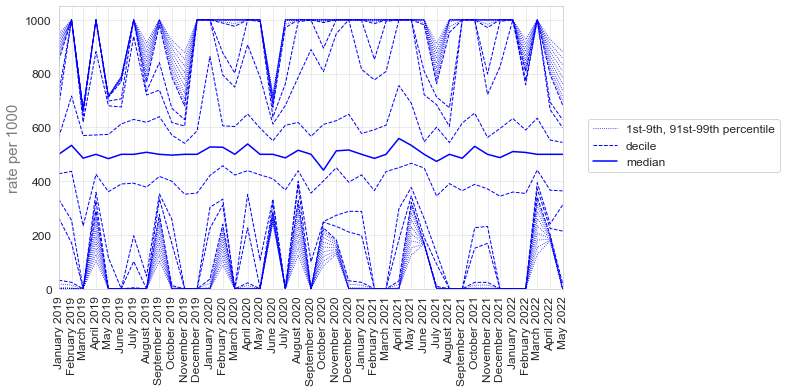

#### Most Common Codes <a href=h>(Codelist 1)</a>, <a href=t>(Codelist 2)</a>

Code,Description,Proportion of codes (%)
1079381000000109,Medication review by community nurse,59.77
1239511000000100,Structured medication review,20.61
1127441000000107,Medication review done by clinical pharmacist,19.63


Total patients: 0.01M (0.00M events)

In [25]:
medication_review_df, num_events_medication_review = generate_sentinel_measure(data_dict, data_dict_practice, codelist_dict, 'medication_review', 'code', 'term', ["2020-02-01", "2020-04-01", "2020-12-01"], codelist_links="https://www.opencodelists.org/codelist/opensafely/care-planning-medication-review-simple-reference-set-nhs-digital/61b13c39/",interactive=INTERACTIVE)
num_events_dict["medication_review"] = num_events_medication_review